# 1. PHẦN MÔ HÌNH K- TRUNG BÌNH (K-MEANS MODEL)

# Ví dụ 1.

In [14]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
np.random.seed(11)
# Kỳ vọng và hiệp phương sai của 3 cụm dữ liệu
means = [[2, 2], [8, 3], [3, 6]]
cov = [[1, 0], [0, 1]]
# Số điểm mỗi cụm dữ liệu
N = 500
# Tạo các cụm dữ liệu qua phân bố chuẩn (Gaussian)
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X2 = np.random.multivariate_normal(means[2], cov, N)
# Tổng hợp dữ liệu từ các cụm
X = np.concatenate((X0, X1, X2), axis = 0)
# Số cụm = 3
K = 3
# Gán nhãn ban đầu cho các cụm, sau đó ta test model và so sánh
original_label = np.asarray([0]*N + [1]*N + [2]*N).T

In [15]:
def kmeans_display(X, label):
    K = np.amax(label) + 1
    X0 = X[label == 0, :]
    X1 = X[label == 1, :]
    X2 = X[label == 2, :]
    plt.plot(X0[:, 0], X0[:, 1], 'b^', markersize = 4, alpha = .8)
    plt.plot(X1[:, 0], X1[:, 1], 'go', markersize = 4, alpha = .8)
    plt.plot(X2[:, 0], X2[:, 1], 'rs', markersize = 4, alpha = .8)
    plt.axis('equal')
    plt.plot()
    plt.show()

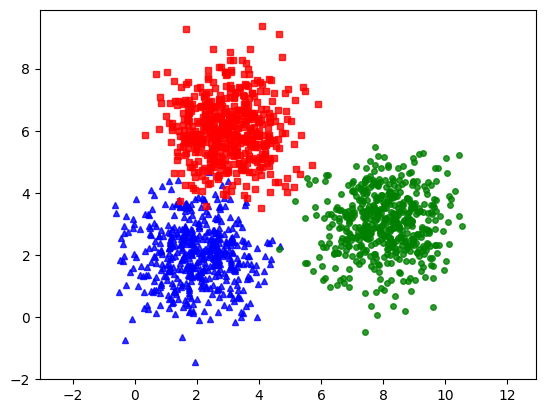

In [16]:
kmeans_display(X, original_label)

In [17]:
def kmeans_init_centers(X, k):
    # randomly pick k rows of X as initial centers
    return X[np.random.choice(X.shape[0], k, replace=False)]

In [18]:
def kmeans_assign_labels(X, centers):
    # calculate pairwise distances btw data and centers
    D = cdist(X, centers)
    # return index of the closest center
    return np.argmin(D, axis = 1)

In [19]:
def kmeans_assign_labels(X, centers):
    # calculate pairwise distances btw data and centers
    D = cdist(X, centers)
    # return index of the closest center
    return np.argmin(D, axis = 1)

In [20]:
def kmeans_update_centers(X, labels, K):
    centers = np.zeros((K, X.shape[1]))
    for k in range(K):
        # collect all points assigned to the k-th cluster
        Xk = X[labels == k, :]
        # take average
        centers[k,:] = np.mean(Xk, axis = 0)
    return centers

In [21]:
def has_converged(centers, new_centers):
    # return True if two sets of centers are the same
    return (set([tuple(a) for a in centers]) == set([tuple(a) for a in new_centers]))

In [22]:
def kmeans(X, K):
    centers = [kmeans_init_centers(X, K)]
    labels = []
    it = 0
    while True:
        labels.append(kmeans_assign_labels(X, centers[-1]))
        new_centers = kmeans_update_centers(X, labels[-1], K)
        if has_converged(centers[-1], new_centers):
            break
        centers.append(new_centers)
        it += 1
    return (centers, labels, it)

Centers found by our algorithm:
[[2.99084705 6.04196062]
 [1.97563391 2.01568065]
 [8.03643517 3.02468432]]


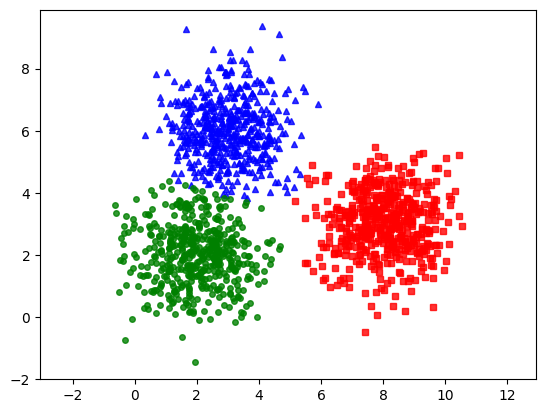

In [23]:
(centers, labels, it) = kmeans(X, K)
print('Centers found by our algorithm:')
print(centers[-1])
kmeans_display(X, labels[-1])

c:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


Centers found by scikit-learn:
[[1.97826939 2.00223913]
 [2.98759958 6.02896527]
 [8.0410628  3.02094748]]


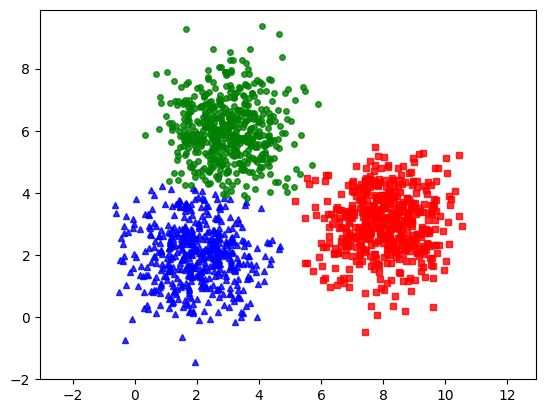

In [24]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
print('Centers found by scikit-learn:')
print(kmeans.cluster_centers_)
pred_label = kmeans.predict(X)
kmeans_display(X, pred_label)

# Ví dụ 2

In [1]:
import numpy as np
from mnist import MNIST
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

In [2]:
def display_network(A, m = -1, n = -1):
    opt_normalize = True
    opt_graycolor = True

    # Rescale
    A = A - np.average(A)

    # Compute rows & cols
    (row, col) = A.shape
    sz = int(np.ceil(np.sqrt(row)))
    buf = 1
    if m < 0 or n < 0:
        n = np.ceil(np.sqrt(col))
        m = np.ceil(col / n)

    image = np.ones(shape=(buf + m * (sz + buf), buf + n * (sz + buf)))

    if not opt_graycolor:
        image *= 0.1

    k = 0

    for i in range(int(m)):
        for j in range(int(n)):
            if k >= col:
                continue

            clim = np.max(np.abs(A[:, k]))

            if opt_normalize:
                image[buf + i * (sz + buf):buf + i * (sz + buf) + sz, buf + j * (sz + buf):buf + j * (sz + buf) + sz] = \
                A[:, k].reshape(sz, sz) / clim
            else:
                image[buf + i * (sz + buf):buf + i * (sz + buf) + sz, buf + j * (sz + buf):buf + j * (sz + buf) + sz] = \
                A[:, k].reshape(sz, sz) / np.max(np.abs(A))

            k += 1
    
    return image

In [3]:
def display_color_network(A):
    """
    # display receptive field(s) or basis vector(s) for image patches
    #
    # A the basis, with patches as column vectors
    # In case the midpoint is not set at 0, we shift it dynamically
    :param A:
    :param file:
    :return:
    """

    if np.min(A) >= 0:
        A = A - np.mean(A)
        
    cols = np.round(np.sqrt(A.shape[1]))
    
    channel_size = A.shape[0] / 3
    dim = np.sqrt(channel_size)
    dimp = dim + 1
    rows = np.ceil(A.shape[1] / cols)

    B = A[0:channel_size, :]
    C = A[channel_size:2 * channel_size, :]
    D = A[2 * channel_size:3 * channel_size, :]

    B = B / np.max(np.abs(B))
    C = C / np.max(np.abs(C))
    D = D / np.max(np.abs(D))

    # Initialization of the image
    image = np.ones(shape=(dim * rows + rows - 1, dim * cols + cols - 1, 3))

    for i in range(int(rows)):
        for j in range(int(cols)):
            # This sets the patch
            image[i * dimp:i * dimp + dim, j * dimp:j * dimp + dim, 0] = B[:, i * cols + j].reshape(dim, dim)
            image[i * dimp:i * dimp + dim, j * dimp:j * dimp + dim, 1] = C[:, i * cols + j].reshape(dim, dim)
            image[i * dimp:i * dimp + dim, j * dimp:j * dimp + dim, 2] = D[:, i * cols + j].reshape(dim, dim)

    image = (image + 1) / 2
    
    return image

In [4]:
import os

# train path
train_images_path = os.path.join('C:\\Users\\Admin\\Desktop\\ML\\week4\\train-images-idx3-ubyte.gz')
train_labels_path = os.path.join('C:\\Users\\Admin\\Desktop\\ML\\week4\\train-labels-idx1-ubyte.gz')
# test path
test_images_path = os.path.join('C:\\Users\\Admin\\Desktop\\ML\\week4\\t10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join('C:\\Users\\Admin\\Desktop\\ML\\week4\\t10k-labels-idx1-ubyte.gz')

def get_mnist_data(images_path, labels_path, num_images, shuffle=False, _is=True, image_size=28):
    """
    This shuffle param is active when .gz is downloaded at:
    - 'http://yann.lecun.com/exdb/mnist/'
    - This function return random num_images in 60000 or 10000
    """

    # read data
    import gzip # to decompress gz (zip) file

    # open file training to read training data
    f_images = gzip.open(images_path,'r')

    # skip 16 first bytes because these are not data, only header infor
    f_images.read(16)

    # general: read num_images data samples if this parameter is set;
    # if not, read all (60000 training or 10000 test)
    real_num = num_images if not shuffle else (60000 if _is else 10000)

    # read all data to buf_images (28x28xreal_num)
    buf_images = f_images.read(image_size * image_size * real_num)

    # images
    images = np.frombuffer(buf_images, dtype=np.uint8).astype(np.float32)
    images = images.reshape(real_num, image_size, image_size,)

    # Read labels
    f_labels = gzip.open(labels_path,'r')
    f_labels.read(8)
    labels = np.zeros((real_num)).astype(np.int64)

    # rearrange to correspond the images and labels
    for i in range(0, real_num):
        buf_labels = f_labels.read(1)
        labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)

    # shuffle to get random images data
    if shuffle is True:
        rand_id = np.random.randint(real_num, size=num_images)
        images = images[rand_id, :]
        labels = labels[rand_id,]
        
    # change images data to type of vector 28x28 dimentional
    images = images.reshape(num_images, image_size * image_size)
    return images

In [5]:
mndata = get_mnist_data(train_images_path, train_labels_path, 5000, shuffle=True)
X = mndata
X0 = np.asarray(X)[:1000,:]/256.0
X = X0
K = 10
kmeans = KMeans(n_clusters=K).fit(X)
pred_label = kmeans.predict(X)

C:\Users\Admin\AppData\Local\Temp\ipykernel_28328\2035614182.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)
c:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


<class 'numpy.ndarray'>
(784, 10)


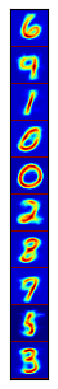

In [6]:
print(type(kmeans.cluster_centers_.T))
print(kmeans.cluster_centers_.T.shape)
A = display_network(kmeans.cluster_centers_.T, K, 1)

f1 = plt.imshow(A, interpolation='nearest', cmap = "jet")
f1.axes.get_xaxis().set_visible(False)
f1.axes.get_yaxis().set_visible(False)
plt.show()
# plt.savefig('a1.png', bbox_inches='tight')

# a colormap and a normalization instance
cmap = plt.cm.jet
norm = plt.Normalize(vmin=A.min(), vmax=A.max())

# map the normalized data to colors
# image is now RGBA (512x512x4)
image = cmap(norm(A))

In [7]:
N0 = 20
X1 = np.zeros((N0*K, 784))
X2 = np.zeros((N0*K, 784))

for k in range(K):
    Xk = X0[pred_label == k, :]

    center_k = [kmeans.cluster_centers_[k]]
    neigh = NearestNeighbors(n_neighbors=N0).fit(Xk)
    dist, nearest_id = neigh.kneighbors(center_k, N0)

    X1[N0*k: N0*k + N0,:] = Xk[nearest_id, :]
    X2[N0*k: N0*k + N0,:] = Xk[:N0, :]

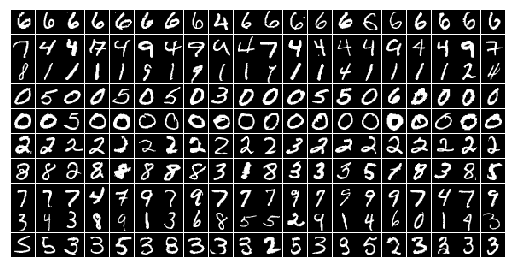

In [8]:
plt.axis('off')
A = display_network(X2.T, K, N0)
f2 = plt.imshow(A, interpolation='nearest' )
plt.gray()
plt.show()

## Bài tập tự thực hành

Bài 1. Hãy áp dụng đoạn chương trình chúng ta tự xây dựng trong ví dụ 1, với dữ liệu là hình ảnh chữ số viết
tay như trong ví dụ 2, chạy để xem xét kết quả.

In [12]:
from sklearn.decomposition import PCA

def apply_pca(X, n_components):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    return X_pca

In [26]:
def kmeans_display(X, label):
    K = np.amax(label) + 1
    X0 = X[label == 0, :]
    X1 = X[label == 1, :]
    X2 = X[label == 2, :]
    plt.plot(X0[:, 0], X0[:, 1], 'b^', markersize = 4, alpha = .8)
    plt.plot(X1[:, 0], X1[:, 1], 'go', markersize = 4, alpha = .8)
    plt.plot(X2[:, 0], X2[:, 1], 'rs', markersize = 4, alpha = .8)
    plt.axis('equal')
    plt.plot()
    plt.show()

In [27]:
def kmeans_init_centers(X, k):
    # randomly pick k rows of X as initial centers
    return X[np.random.choice(X.shape[0], k, replace=False)]

In [28]:
def kmeans_assign_labels(X, centers):
    # calculate pairwise distances btw data and centers
    D = cdist(X, centers)
    # return index of the closest center
    return np.argmin(D, axis = 1)

In [29]:
def kmeans_update_centers(X, labels, K):
    centers = np.zeros((K, X.shape[1]))
    for k in range(K):
        # collect all points assigned to the k-th cluster
        Xk = X[labels == k, :]
        # take average
        centers[k,:] = np.mean(Xk, axis = 0)
    return centers

In [30]:
def has_converged(centers, new_centers):
    # return True if two sets of centers are the same
    return (set([tuple(a) for a in centers]) == set([tuple(a) for a in new_centers]))

In [31]:
def kmeans(X, K):
    centers = [kmeans_init_centers(X, K)]
    labels = []
    it = 0
    while True:
        labels.append(kmeans_assign_labels(X, centers[-1]))
        new_centers = kmeans_update_centers(X, labels[-1], K)
        if has_converged(centers[-1], new_centers):
            break

        centers.append(new_centers)
        it += 1
    return (centers, labels, it)

C:\Users\Admin\AppData\Local\Temp\ipykernel_28328\2035614182.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)


Centers found by our algorithm:
[[1246.49243164 -103.08449554  527.40820312]
 [ 237.52050781  592.73217773 -608.09228516]
 [ 379.55429077  -75.08860779  667.18823242]
 [-198.73974609 -673.17022705  194.42443848]
 [-328.89782715   77.84347534  442.16213989]
 [ 951.34820557  254.90812683 -205.11820984]
 [ 179.91049194 -669.41009521 -381.25405884]
 [-416.15344238 -298.0758667  -368.56335449]
 [  97.92922974  334.26324463   37.94881821]
 [-767.59985352  444.58590698  130.86160278]]


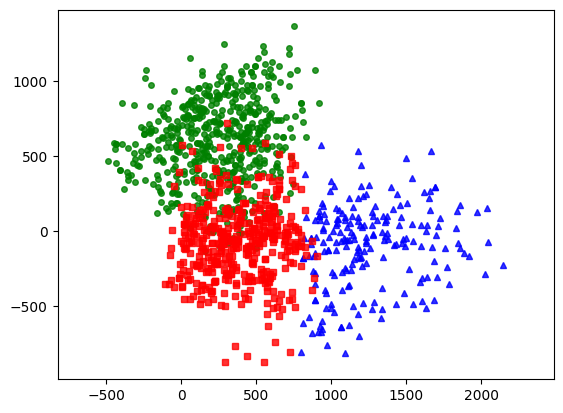

In [33]:
# Lấy dữ liệu MNIST
mndata = get_mnist_data(train_images_path, train_labels_path, 5000, shuffle=True)
X = np.asarray(mndata)

# Áp dụng PCA để giảm chiều dữ liệu
n_components = 3
X_pca = apply_pca(X, n_components)

# Áp dụng k-means trên dữ liệu giảm chiều
K = 10
(centers, labels, it) = kmeans(X_pca, K)

print('Centers found by our algorithm:')
print(centers[-1])

# Hiển thị kết quả phân cụm
kmeans_display(X_pca, labels[-1])

Bài 2. Áp dụng mô hình trên cho bài tập phân loại ảnh chó-mèo (xem lại phần CNN), thử thực hiện phân
cụm thành 02 cụm và kiểm tra kết quả.

In [35]:
import os
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

# Function to load and preprocess images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img = cv2.resize(img, (100, 100))  # Resize images for consistency
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            images.append(img)
    return images

# Load images of cats and dogs
cats_folder = "C:\\Users\\Admin\\Desktop\\ML\\week8\\cats_and_dogs_filtered\\train\\cats"
dogs_folder = "C:\\Users\\Admin\\Desktop\\ML\\week8\\cats_and_dogs_filtered\\train\\dogs"
cats_images = load_images_from_folder(cats_folder)
dogs_images = load_images_from_folder(dogs_folder)

# Extract features (for simplicity, let's use flattened RGB pixel values as features)
cats_features = np.array([img.flatten() for img in cats_images])
dogs_features = np.array([img.flatten() for img in dogs_images])

# Combine features of cats and dogs
X = np.vstack((cats_features, dogs_features))

# Apply k-means clustering
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)

# Get cluster labels
cluster_labels = kmeans.labels_

# Since k-means assigns arbitrary labels, we need to map them to represent cats and dogs
# For example, if the majority of cluster 0 corresponds to cats, then label 0 represents cats
cat_label = np.argmax(np.bincount(cluster_labels[:len(cats_features)]))
dog_label = 1 - cat_label  # The other label represents dogs

# Map cluster labels to represent cats and dogs
mapped_labels = np.where(cluster_labels == cat_label, 0, 1)

# Calculate accuracy
true_labels = np.concatenate((np.zeros(len(cats_features)), np.ones(len(dogs_features))))
accuracy = accuracy_score(true_labels, mapped_labels)
print("Accuracy:", accuracy)

Accuracy: 0.5205


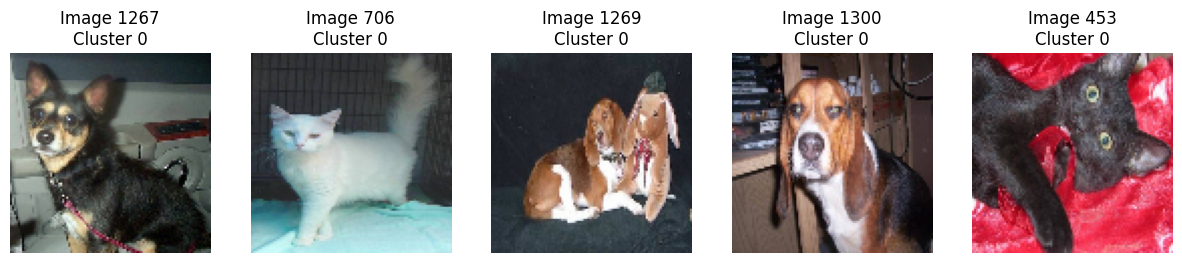

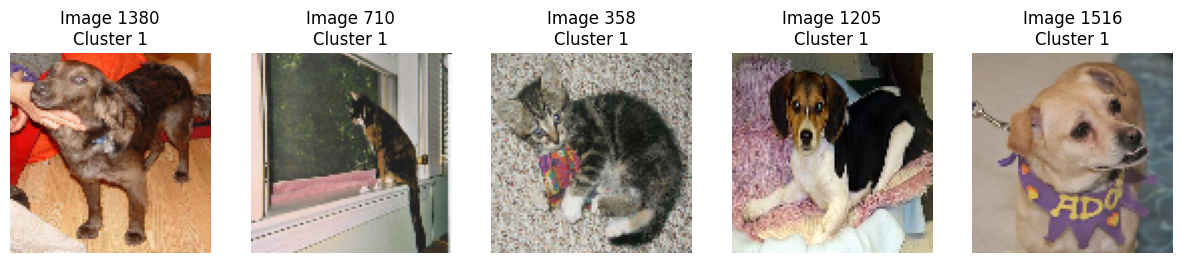

In [36]:
import matplotlib.pyplot as plt

# Function to plot sample images from each cluster
def plot_cluster_samples(images, labels, cluster_label, num_samples=5):
    cluster_indices = np.where(labels == cluster_label)[0]
    sample_indices = np.random.choice(cluster_indices, size=num_samples, replace=False)
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(sample_indices):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[idx].reshape(100, 100, 3))  # Reshape back to original image dimensions
        plt.axis('off')
        plt.title(f"Image {idx}\nCluster {cluster_label}")

# Plot sample images from each cluster
plot_cluster_samples(X, mapped_labels, 0)  # Cluster 0
plt.show()

plot_cluster_samples(X, mapped_labels, 1)  # Cluster 1
plt.show()

# 2. PHẦN MÔ HÌNH TRỘN GAUSSIAN (GAUSSIAN MIXTURE MODEL)

# Ví dụ 1

In [9]:
def gen_data(k=3, dim=2, points_per_cluster=200, lim=[-20, 20]):
    '''
    Generates data from a random mixture of Gaussians in a given range. Will also
    plot the points in case of 2D. input:
    - k: Number of Gaussian clusters
    - dim: Dimension of generated points
    - points_per_cluster: Number of points to be generated for each cluster
    - lim: Range of mean values
    output:
    - X: Generated points (points_per_cluster*k, dim)
    '''
    x = []
    mean = random.rand(k, dim)*(lim[1]-lim[0]) + lim[0]
    for i in range(k):
        cov = random.rand(dim, dim+10)
        cov = np.matmul(cov, cov.T)
        _x = np.random.multivariate_normal(mean[i], cov, points_per_cluster)
        x += list(_x)
    x = np.array(x)
    if(dim == 2):
        fig = plt.figure()
        ax = fig.gca()
        ax.scatter(x[:,0], x[:,1], s=3, alpha=0.4)
        ax.autoscale(enable=True)
    return x

Phần khởi tạo cho thuật toán lặp

In [8]:
def __init__(self, k, dim, init_mu=None, init_sigma=None, init_pi=None, colors=None):
    '''
    Define a model with known number of clusters and dimensions.
    input:
    - k: Number of Gaussian clusters
    - dim: Dimension
    - init_mu: initial value of mean of clusters (k, dim)
    (default) random from uniform[-10, 10]
    - init_sigma: initial value of covariance matrix of clusters (k, dim, dim)
    (default) Identity matrix for each cluster
    - init_pi: initial value of cluster weights (k,)
    (default) equal value to all cluster i.e. 1/k
    - colors: Color valu for plotting each cluster (k, 3)
    (default) random from uniform[0, 1]
    '''
    self.k = k
    self.dim = dim
    if(init_mu is None):
        init_mu = random.rand(k, dim)*20 - 10
    self.mu = init_mu
    if(init_sigma is None):
        init_sigma = np.zeros((k, dim, dim))
        for i in range(k):
            init_sigma[i] = np.eye(dim)
    self.sigma = init_sigma
    if(init_pi is None):
        init_pi = np.ones(self.k)/self.k
    self.pi = init_pi
    if(colors is None):
        colors = random.rand(k, 3)
    self.colors = colors

In [10]:
def e_step(self):
    '''
    E-step of EM algorithm.
    '''
    for i in range(self.k):
        self.z[:, i] = self.pi[i] * multivariate_normal.pdf(self.data,mean=self.mu[i], cov=self.sigma[i])
    self.z /= self.z.sum(axis=1, keepdims=True)

In [2]:
import numpy as np
from numpy import random
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import multivariate_normal

class GMM():
    def __init__(self, k, dim, init_mu=None, init_sigma=None, init_pi=None, colors=None):
        '''
        Define a model with known number of clusters and dimensions.
        input:
            - k: Number of Gaussian clusters
            - dim: Dimension 
            - init_mu: initial value of mean of clusters (k, dim)
                       (default) random from uniform[-10, 10]
            - init_sigma: initial value of covariance matrix of clusters (k, dim, dim)
                          (default) Identity matrix for each cluster
            - init_pi: initial value of cluster weights (k,)
                       (default) equal value to all cluster i.e. 1/k
            - colors: Color valu for plotting each cluster (k, 3)
                      (default) random from uniform[0, 1]
        '''
        self.k = k
        self.dim = dim
        if(init_mu is None):
            init_mu = random.rand(k, dim)*20 - 10
        self.mu = init_mu
        if(init_sigma is None):
            init_sigma = np.zeros((k, dim, dim))
            for i in range(k):
                init_sigma[i] = np.eye(dim)
        self.sigma = init_sigma
        if(init_pi is None):
            init_pi = np.ones(self.k)/self.k
        self.pi = init_pi
        if(colors is None):
            colors = random.rand(k, 3)
            for i in range(k):
                colors[i, 2] = i/k
        self.colors = colors
    
    def init_em(self, X):
        '''
        Initialization for EM algorithm.
        input:
            - X: data (batch_size, dim)
        '''
        self.data = X
        self.num_points = X.shape[0]
        self.z = np.zeros((self.num_points, self.k))
    
    def e_step(self):
        '''
        E-step of EM algorithm.
        '''
        for i in range(self.k):
            self.z[:, i] = self.pi[i] * multivariate_normal.pdf(self.data, mean=self.mu[i], cov=self.sigma[i])
        self.z /= self.z.sum(axis=1, keepdims=True)
    
    def m_step(self):
        '''
        M-step of EM algorithm.
        '''
        sum_z = self.z.sum(axis=0)
        self.pi = sum_z / self.num_points
        self.mu = np.matmul(self.z.T, self.data)
        self.mu /= sum_z[:, None]
        for i in range(self.k):
            j = np.expand_dims(self.data, axis=1) - self.mu[i]
            s = np.matmul(j.transpose([0, 2, 1]), j)
            self.sigma[i] = np.matmul(s.transpose(1, 2, 0), self.z[:, i] )
            self.sigma[i] /= sum_z[i]
            
    def log_likelihood(self, X):
        '''
        Compute the log-likelihood of X under current parameters
        input:
            - X: Data (batch_size, dim)
        output:
            - log-likelihood of X: Sum_n Sum_k log(pi_k * N( X_n | mu_k, sigma_k ))
        '''
        ll = []
        for d in X:
            tot = 0
            for i in range(self.k):
                tot += self.pi[i] * multivariate_normal.pdf(d, mean=self.mu[i], cov=self.sigma[i])
            ll.append(np.log(tot))
        return np.sum(ll)
    
    def plot_gaussian(self, mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
        '''
        Utility function to plot one Gaussian from mean and covariance.
        '''
        pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0),
            width=ell_radius_x * 2,
            height=ell_radius_y * 2,
            facecolor=facecolor,
            **kwargs)
        scale_x = np.sqrt(cov[0, 0]) * n_std
        mean_x = mean[0]
        scale_y = np.sqrt(cov[1, 1]) * n_std
        mean_y = mean[1]
        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)
        ellipse.set_transform(transf + ax.transData)
        return ax.add_patch(ellipse)

    def draw(self, ax, n_std=2.0, facecolor='none', **kwargs):
        '''
        Function to draw the Gaussians.
        Note: Only for two-dimensionl dataset
        '''
        if(self.dim != 2):
            print("Drawing available only for 2D case.")
            return
        for i in range(self.k):
            self.plot_gaussian(self.mu[i], self.sigma[i], ax, n_std=n_std, edgecolor=self.colors[i], **kwargs)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [11]:
def gen_data(k=3, dim=2, points_per_cluster=200, lim=[-10, 10]):
    '''
    Generates data from a random mixture of Gaussians in a given range.
    Will also plot the points in case of 2D.
    input:
        - k: Number of Gaussian clusters
        - dim: Dimension of generated points
        - points_per_cluster: Number of points to be generated for each cluster
        - lim: Range of mean values
    output:
        - X: Generated points (points_per_cluster*k, dim)
    '''
    x = []
    mean = random.rand(k, dim)*(lim[1]-lim[0]) + lim[0]
    for i in range(k):
        cov = random.rand(dim, dim+10)
        cov = np.matmul(cov, cov.T)
        _x = np.random.multivariate_normal(mean[i], cov, points_per_cluster)
        x += list(_x)
    x = np.array(x)
    if(dim == 2):
        fig = plt.figure()
        ax = fig.gca()
        ax.scatter(x[:,0], x[:,1], s=3, alpha=0.4)
        ax.autoscale(enable=True) 
    return x

In [3]:
def plot(title):
    '''
    Draw the data points and the fitted mixture model.
    input:
        - title: title of plot and name with which it will be saved.
    '''
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    ax.scatter(X[:, 0], X[:, 1], s=3, alpha=0.4)
    ax.scatter(gmm.mu[:, 0], gmm.mu[:, 1], c=gmm.colors)
    gmm.draw(ax, lw=3)
    ax.set_xlim((-22, 22))
    ax.set_ylim((-22, 22))
    
    plt.title(title)
    plt.savefig(title.replace(':', '_'))
    plt.show()
    plt.clf()

Bài tập tự thực hành 1: Sử dụng đoạn code trên để áp dựng cho dữ liệu là phần đầu vào của tập dữ liệu hoa
Iris (bỏ trường tên loại hoa). Sau khi phân cụm xong hãy đối sánh kết quả với các phân loại đúng.

In [1]:
from sklearn import datasets 
from sklearn.preprocessing import StandardScaler
iris = datasets.load_iris() 

X = iris.data
Y = iris.target

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Drawing available only for 2D case.


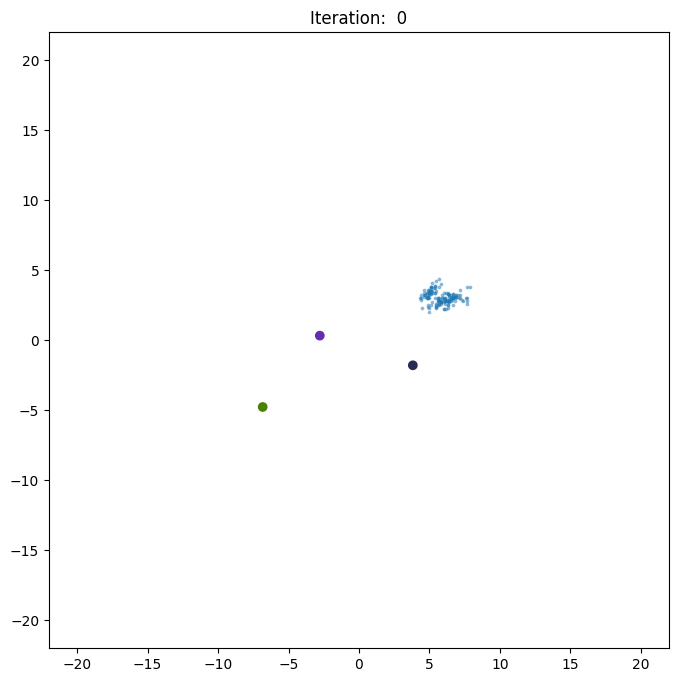

Iteration: 1, log-likelihood: -462.4009
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

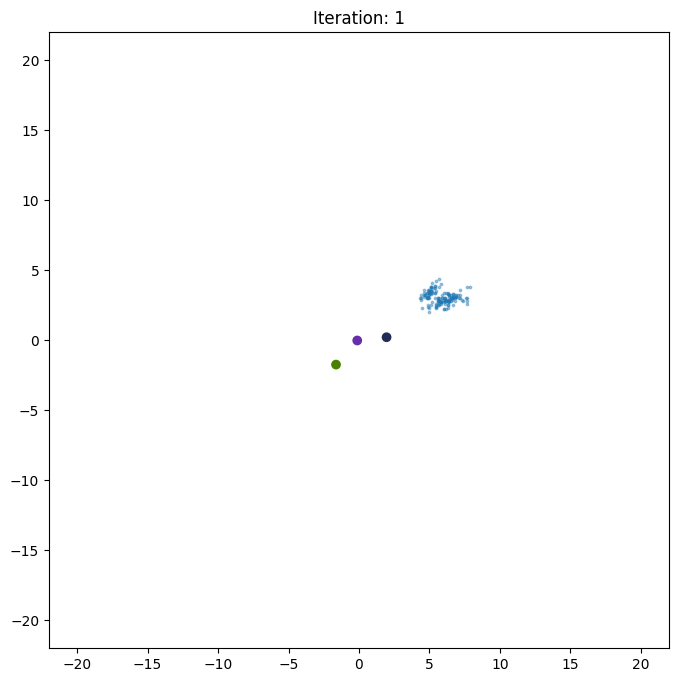

LinAlgError: When `allow_singular is False`, the input matrix must be symmetric positive definite.

<Figure size 640x480 with 0 Axes>

In [5]:
# Initialize GMM model with 3 clusters and 4 dimensions (features)
gmm = GMM(k=3, dim=4)

# Initialize GMM with Iris data
gmm.init_em(X_scaled)

num_iters = 20
# Saving log-likelihood
log_likelihood = [gmm.log_likelihood(X_scaled)]
# Plotting
plot("Iteration:  0")
for e in range(num_iters):
    # E-step
    gmm.e_step()
    # M-step
    gmm.m_step()
    # Computing log-likelihood
    log_likelihood.append(gmm.log_likelihood(X_scaled))
    print("Iteration: {}, log-likelihood: {:.4f}".format(e+1, log_likelihood[-1]))
    # Plotting
    plot(title="Iteration: " + str(e+1))

Bài tập tự thực hành 2: Hãy sử dụng thuật toán K-means để phân cụm dữ liệu tự tạo đã có trong ví dụ 1 của phần này. So sánh và giải thích kết quả.

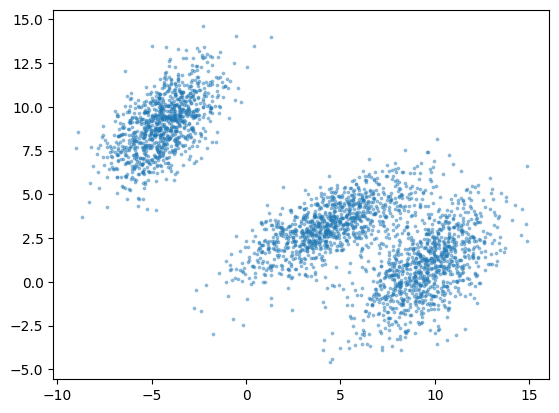

In [12]:
# Generate random 2D data with 3 clusters 
X = gen_data(k=3, dim=2, points_per_cluster=1000)

In [13]:
# Create a Gaussian Mixture Model
gmm = GMM(3, 2)

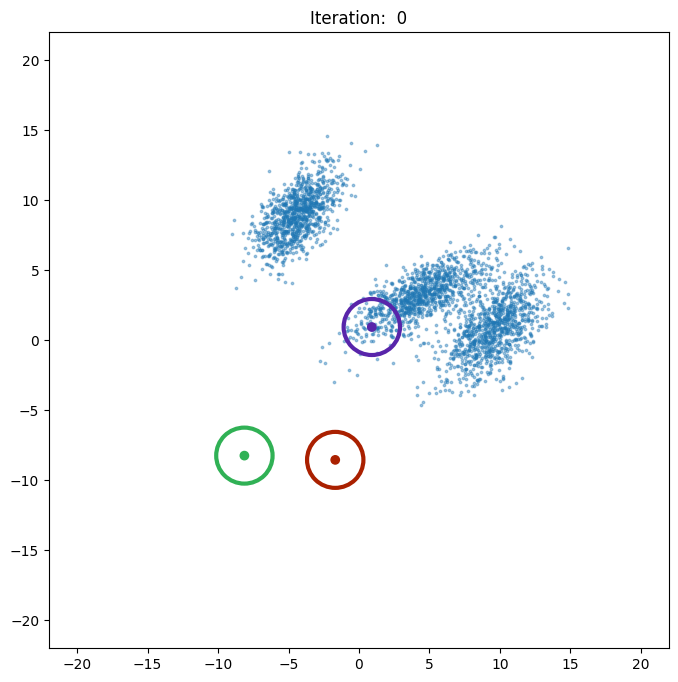

Iteration: 1, log-likelihood: -16659.8114


<Figure size 640x480 with 0 Axes>

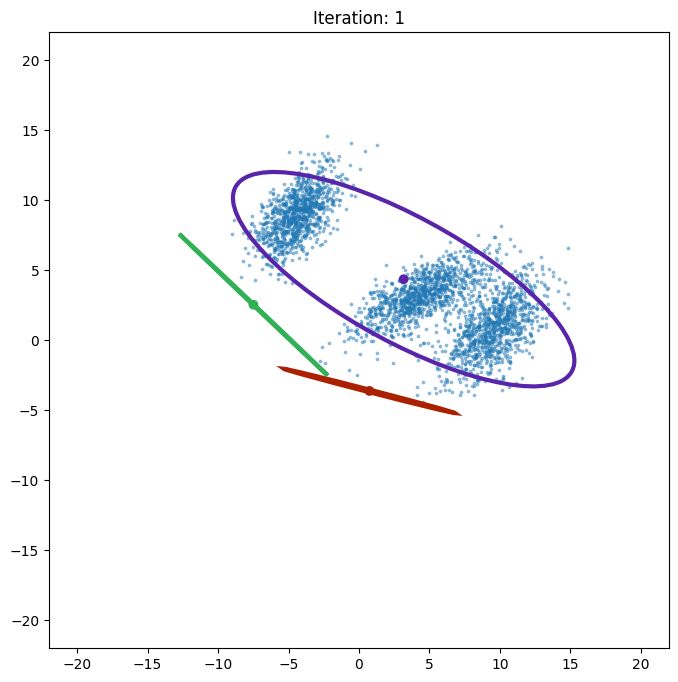

LinAlgError: When `allow_singular is False`, the input matrix must be symmetric positive definite.

<Figure size 640x480 with 0 Axes>

In [14]:
# Training the GMM using EM

# Initialize EM algo with data
gmm.init_em(X)

num_iters = 20
# Saving log-likelihood
log_likelihood = [gmm.log_likelihood(X)]
# plotting
plot("Iteration:  0")
for e in range(num_iters):
    # E-step
    gmm.e_step()
    # M-step
    gmm.m_step()
    # Computing log-likelihood
    log_likelihood.append(gmm.log_likelihood(X))
    print("Iteration: {}, log-likelihood: {:.4f}".format(e+1, log_likelihood[-1]))
    # plotting
    plot(title="Iteration: " + str(e+1))

In [15]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

np.random.seed(11)

# Số điểm mỗi cụm dữ liệu
N = 500

# Số cụm = 3
K = 3

# # Gán nhãn ban đầu cho các cụm, sau đó ta test model và so sánh
# original_label = np.asarray([0]*N + [1]*N + [2]*N).T

def kmeans_display(X, label):
    K = np.amax(label) + 1
    X0 = X[label == 0, :]
    X1 = X[label == 1, :]
    X2 = X[label == 2, :]
    plt.plot(X0[:, 0], X0[:, 1], 'b^', markersize = 4, alpha = .8)
    plt.plot(X1[:, 0], X1[:, 1], 'go', markersize = 4, alpha = .8)
    plt.plot(X2[:, 0], X2[:, 1], 'rs', markersize = 4, alpha = .8)

    plt.xlim(-20, 20)
    plt.ylim(-20, 20)
    
    plt.axis('equal')
    plt.plot()
    plt.show()

def kmeans_init_centers(X, k):
    # randomly pick k rows of X as initial centers
    return X[np.random.choice(X.shape[0], k, replace=False)]

def kmeans_assign_labels(X, centers):
    # calculate pairwise distances btw data and centers
    D = cdist(X, centers)
    # return index of the closest center
    return np.argmin(D, axis = 1)

def kmeans_update_centers(X, labels, K):
    centers = np.zeros((K, X.shape[1]))
    for k in range(K):
        # collect all points assigned to the k-th cluster
        Xk = X[labels == k, :]
        # take average
        centers[k,:] = np.mean(Xk, axis = 0)
    return centers

def has_converged(centers, new_centers):
    # return True if two sets of centers are the same
    return (set([tuple(a) for a in centers]) == set([tuple(a) for a in new_centers]))

def kmeans(X, K):
    centers = [kmeans_init_centers(X, K)]
    labels = []
    it = 0
    while True:
        labels.append(kmeans_assign_labels(X, centers[-1]))
        new_centers = kmeans_update_centers(X, labels[-1], K)
        if has_converged(centers[-1], new_centers):
            break

        centers.append(new_centers)
        it += 1
    return (centers, labels, it)

Centers found by our algorithm:
[[ 4.00708139  2.96549972]
 [ 9.56092956  1.23340322]
 [-4.39684253  8.99870083]]


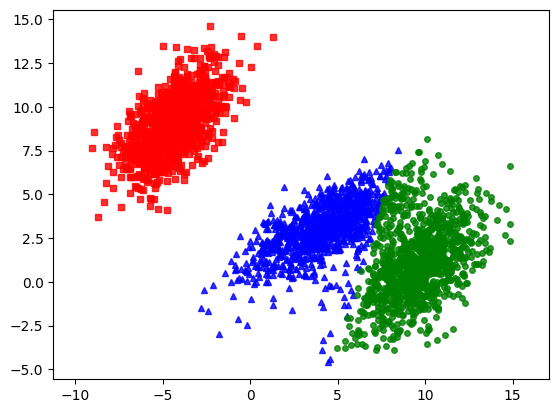

In [16]:
(centers, labels, it) = kmeans(X, K)
print('Centers found by our algorithm:')
print(centers[-1])

kmeans_display(X, labels[-1])

- Nhận xét: Trong phân tích dữ liệu sử dụng hai phương pháp, GMM và KMeans, có thể nhận thấy sự tương đồng giữa ba cụm được phân chia. Tuy nhiên, trong biểu đồ của GMM, một số giá trị không thuộc về bất kỳ cụm nào và nằm ngoài vòng tròn của các cụm, trong khi đó, trong biểu đồ của KMeans, các điểm được gán vào cụm có tâm gần nhất.

# Ví dụ 2

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from matplotlib.patches import Ellipse
from sklearn.preprocessing import MinMaxScaler

from sklearn.mixture import GaussianMixture
# Thư viện chứa model Gaussian Mixture

In [23]:
data = pd.read_csv("shopping-data.csv", header=0, index_col=0)
print(data.shape)
data.head()

# Lấy ra thu nhập va điểm shopping
X = data.iloc[:, 2:4].values

# Chuẩn hoá dữ liệu
std = MinMaxScaler()
X_std = std.fit_transform(X)
print(X_std.shape)

(200, 4)
(200, 2)


In [24]:
# Khởi tạo đối tượng mô hình GaussianMixture
gm = GaussianMixture(n_components=5, covariance_type='full', random_state=0)

gm.fit(X_std)
print('means: \n', gm.means_)
print('covariances: \n ', gm.covariances_)

means: 
 [[0.33368985 0.49394756]
 [0.60502531 0.15433196]
 [0.58393969 0.82673863]
 [0.09861098 0.21597752]
 [0.0829305  0.80743088]]
covariances: 
  [[[ 0.00613567 -0.00231927]
  [-0.00231927  0.0051635 ]]

 [[ 0.01818446  0.00433814]
  [ 0.00433814  0.00873064]]

 [[ 0.01808598 -0.00031096]
  [-0.00031096  0.0091568 ]]

 [[ 0.00453005  0.00255303]
  [ 0.00255303  0.01918353]]

 [[ 0.00337483 -0.0001437 ]
  [-0.0001437   0.01026088]]]


c:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


c:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

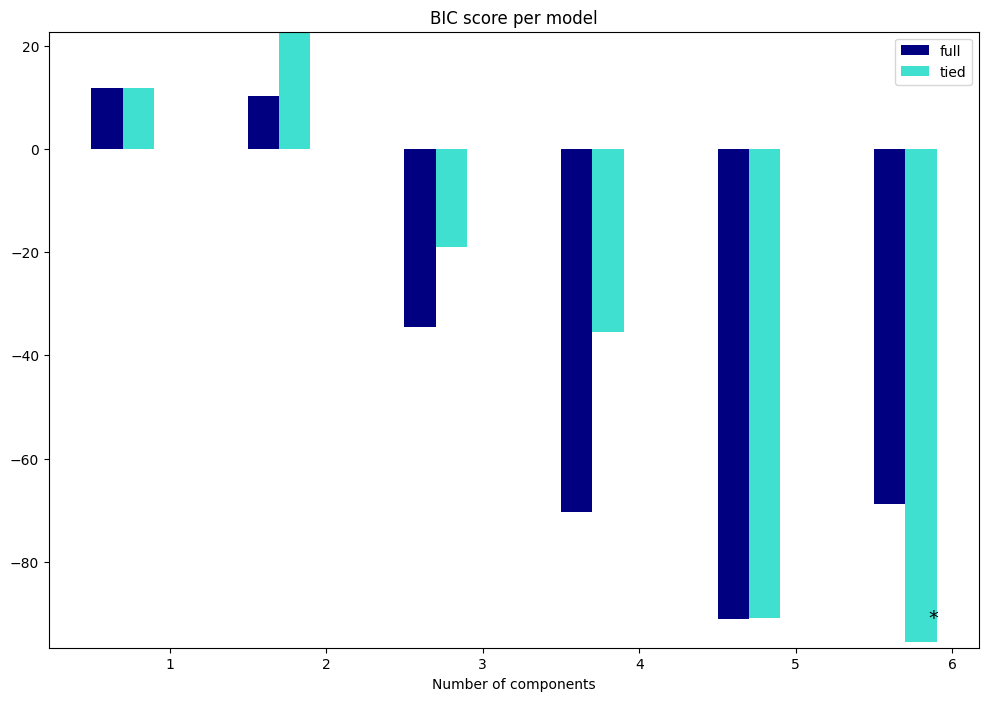

In [25]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
# cv_types = ['spherical', 'tied', 'diag', 'full']
cv_types = ['full', 'tied']
for cv_type in cv_types:
    for n_components in n_components_range:

        # Fit Gaussian mixture theo phương pháp huấn luyện EM
        gmm = GaussianMixture(n_components=n_components,
        covariance_type=cv_type)
        gmm.fit(X_std)
        bic.append(gmm.bic(X_std))

        # Gán model có BIC scores thấp nhất là model tốt nhất
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise'])
clf = best_gmm
bars = []

# Vẽ biểu đồ BIC scores
plt.figure(figsize=(12, 8))
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):(i + 1) * len(n_components_range)], width=.2, color=color))

plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')

xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 + .2 * np.floor(bic.argmin() / len(n_components_range))

plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
plt.xlabel('Number of components')
plt.legend([b[0] for b in bars], cv_types)

In [26]:
def _plot_kmean_scatter(X, labels):
    '''
    X: dữ liệu đầu vào
    labels: nhãn dự báo
    '''
    # lựa chọn màu sắc
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("hls", num_classes))
    
    # vẽ biểu đồ scatter
    fig = plt.figure(figsize=(12, 8))
    ax = plt.subplot()
    sc = ax.scatter(X[:,0], X[:,1], lw=0, s=40, c=palette[labels.astype(np.int_)])

    # thêm nhãn cho mỗi cluster
    txts = []
    for i in range(num_classes):
        # Vẽ text tên cụm tại trung vị của mỗi cụm
        xtext, ytext = np.median(X[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([ PathEffects.Stroke(linewidth=5, foreground="w"), PathEffects.Normal()])
        txts.append(txt)
    plt.title('t-sne visualization')

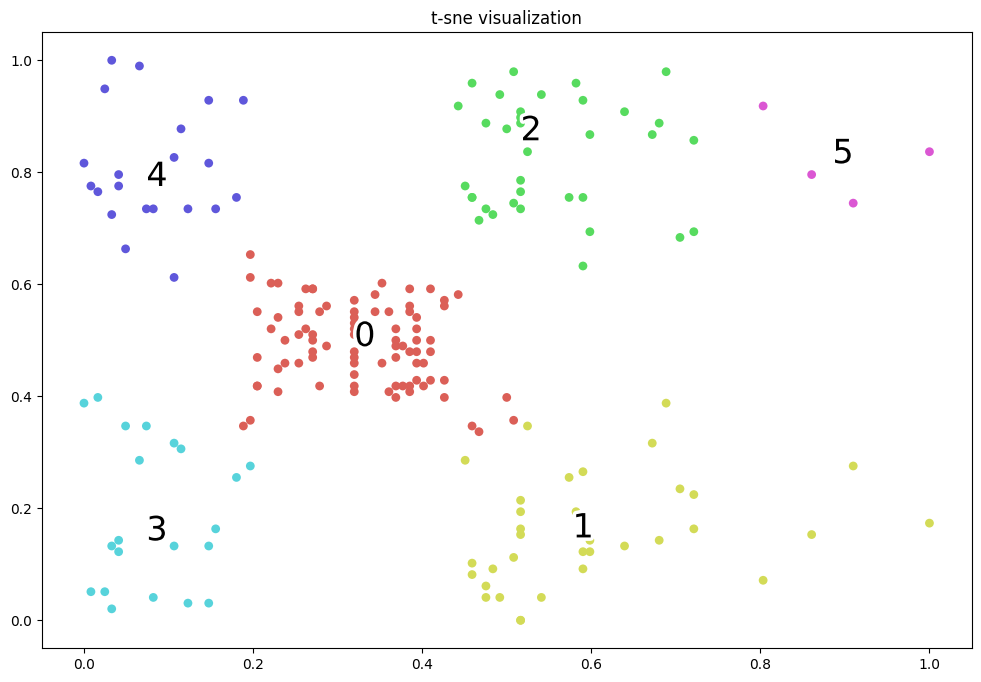

In [27]:
labels = best_gmm.predict(X_std)
_plot_kmean_scatter(X_std, labels)

# 2.3.Ví dụ mở rộng

In [28]:
data = pd.read_csv("Sales_Transactions_Dataset_Weekly.csv", header=0, index_col=0)
print(data.shape)
data.head()

# Lấy ra các cột Normalized
X = data.iloc[:, 55:].values

# Chuẩn hoá dữ liệu
std = MinMaxScaler()
X_std = std.fit_transform(X)
print(X_std.shape)

(811, 106)
(811, 51)


In [29]:
from sklearn.decomposition import PCA 
pca = PCA(n_components=2)
X_std = pca.fit_transform(X_std)
X_std.shape

(811, 2)

In [30]:
# Khởi tạo đối tượng mô hình GaussianMixture
gm = GaussianMixture(n_components=5, covariance_type='full', random_state=0)

gm.fit(X_std)
print('means: \n', gm.means_)
print('covariances: \n ', gm.covariances_)

means: 
 [[ 1.19800155  0.14091181]
 [-1.31959569 -0.34116876]
 [ 0.09409719  0.35137853]
 [ 1.68189176 -0.3492365 ]
 [-0.70523738  0.14721528]]
covariances: 
  [[[ 0.13134588 -0.00737023]
  [-0.00737023  0.11270987]]

 [[ 0.11248466  0.00262615]
  [ 0.00262615  0.08646256]]

 [[ 0.12821586  0.00157575]
  [ 0.00157575  0.11531649]]

 [[ 0.05371215 -0.00992108]
  [-0.00992108  0.06106473]]

 [[ 0.08506355 -0.02479664]
  [-0.02479664  0.14303551]]]


c:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Yêu cầu: Hãy dựa vào ví dụ 1, mở rộng áp dụng với dữ liệu trên đây. Biết rằng số cụm tối ưu sẽ nằm
trong khoảng từ 5 đến 15, hãy xác định số cụm và sau đó phân các mã sản phẩm thành các cụm dựa
trên tiêu chí lượng giao dịch đã cho trong dữ liệu.

c:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

5


c:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

5
6


c:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

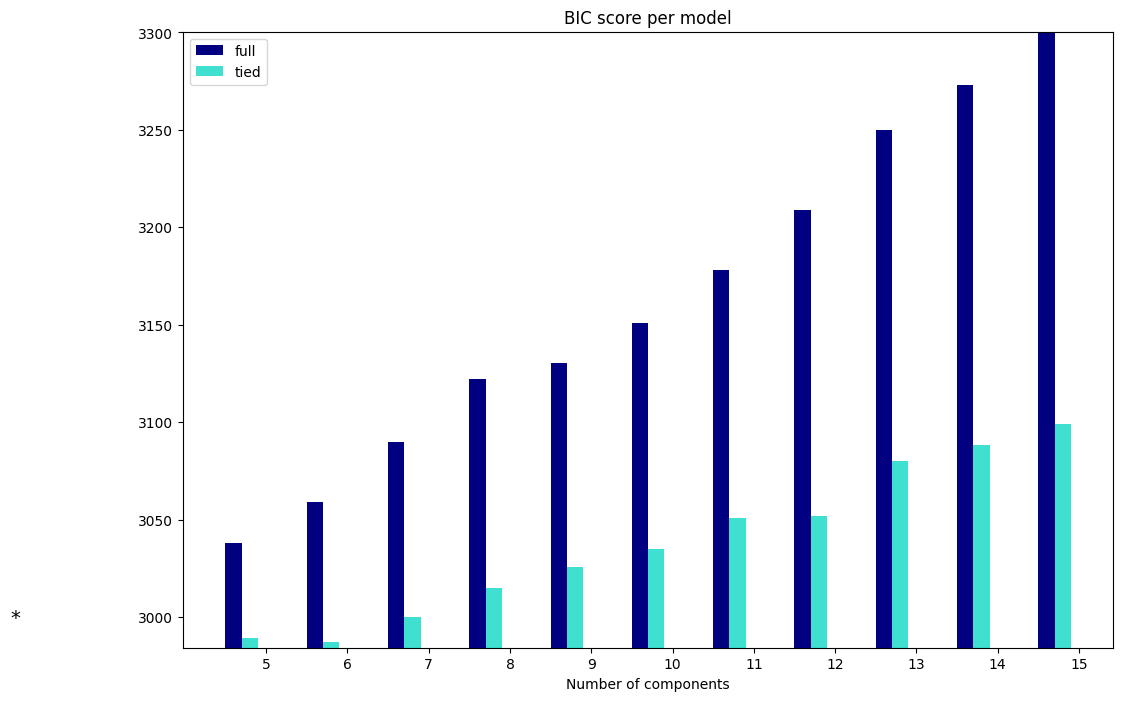

In [31]:
lowest_bic = np.infty
bic = []

# từ 5 - 15
n_components_range = range(5, 16)

# cv_types = ['spherical', 'tied', 'diag', 'full']
cv_types = ['full', 'tied']
for cv_type in cv_types:
    for n_components in n_components_range:

        # Fit Gaussian mixture theo phương pháp huấn luyện EM
        gmm = GaussianMixture(n_components=n_components,
        covariance_type=cv_type)
        gmm.fit(X_std)
        bic.append(gmm.bic(X_std))

        # Gán model có BIC scores thấp nhất là model tốt nhất
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
            print(n_components)

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise'])
clf = best_gmm
bars = []

# Vẽ biểu đồ BIC scores
plt.figure(figsize=(12, 8))
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):(i + 1) * len(n_components_range)], width=.2, color=color))

plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')

xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 + .2 * np.floor(bic.argmin() / len(n_components_range))

plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
plt.xlabel('Number of components')
plt.legend([b[0] for b in bars], cv_types)

* Nhận xét: số cụm tốt nhất là 6

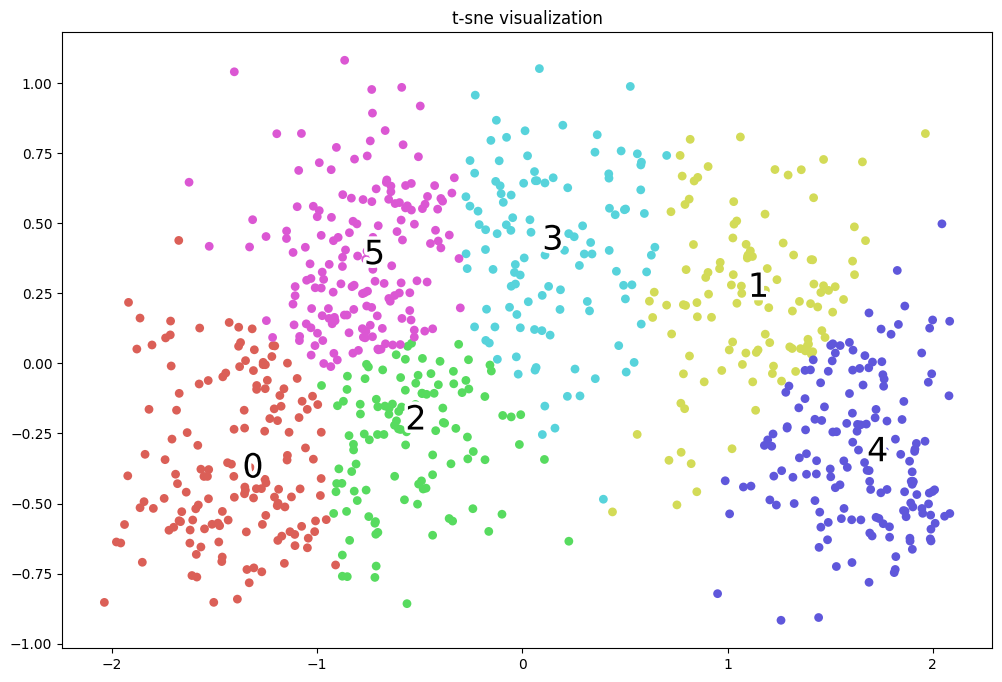

In [32]:
def _plot_kmean_scatter(X, labels):
    '''
    X: dữ liệu đầu vào
    labels: nhãn dự báo
    '''
    # lựa chọn màu sắc
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("hls", num_classes))
    
    # vẽ biểu đồ scatter
    fig = plt.figure(figsize=(12, 8))
    ax = plt.subplot()
    sc = ax.scatter(X[:,0], X[:,1], lw=0, s=40, c=palette[labels.astype(np.int_)])

    # thêm nhãn cho mỗi cluster
    txts = []
    for i in range(num_classes):
        # Vẽ text tên cụm tại trung vị của mỗi cụm
        xtext, ytext = np.median(X[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([ PathEffects.Stroke(linewidth=5, foreground="w"), PathEffects.Normal()])
        txts.append(txt)
    plt.title('t-sne visualization')

labels = best_gmm.predict(X_std)
_plot_kmean_scatter(X_std, labels)